# A/B testing of CTR 
   In this notebook we will present A/B test of CTR ("Click Trough Rate") for some company, so we could decide -- to launch new feature or not. To do this, we'll do such steps:
   1) Prepare dataset for futher work;
   2) Calculate ratres;
   3) Conduct several hypothesis tests.

Usually we choose only one test, based on our information, but we will provide several tests to see the difference.

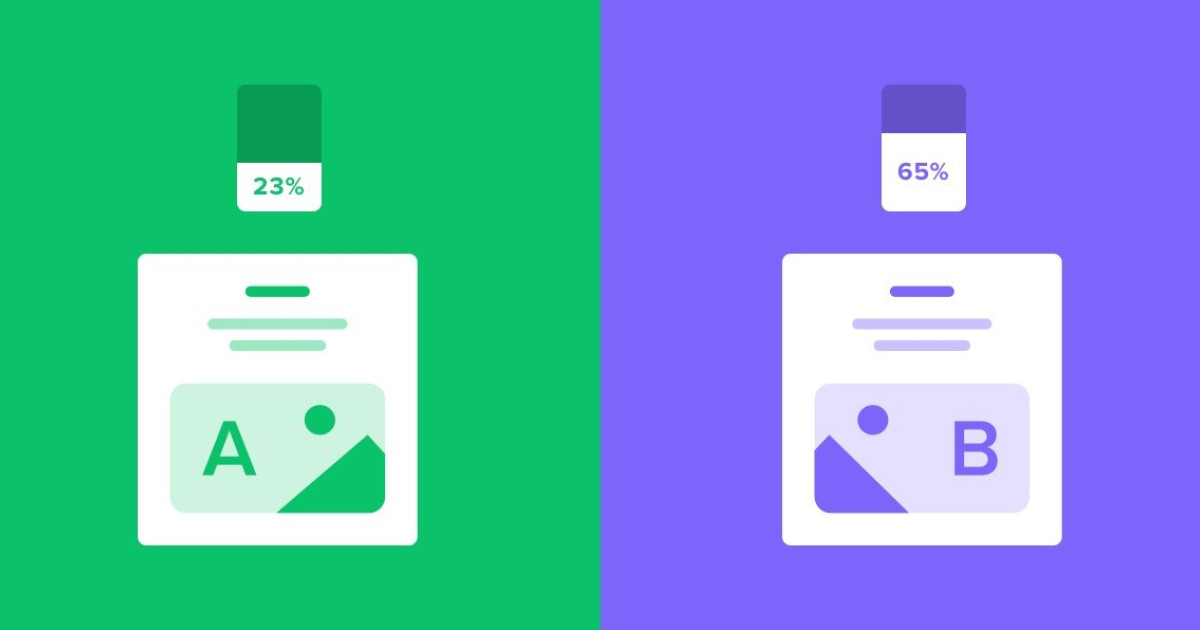

## Import libraries

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

## Prepare data

In [3]:
df = pd.read_csv(r'C:\Users\Микита\Desktop\AB_testing\ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.shape

(294478, 5)


Next we have to delete rows where users appear more than once. It's necessarily due to the fact that in other way we will have bias data.

In [5]:
df = df.drop_duplicates(['user_id'])
df.shape

(290584, 5)

As we can see, number of rows decrease (just as we expected)

In [6]:

conversion_rates = df.groupby('group')['converted']
conversion_rates = conversion_rates.agg([np.mean])
conversion_rates.columns = ['conversion_rate']
conversion_rates.style.format('{:.3f}')


,conversion_rate
group,
control,0.120
treatment,0.119


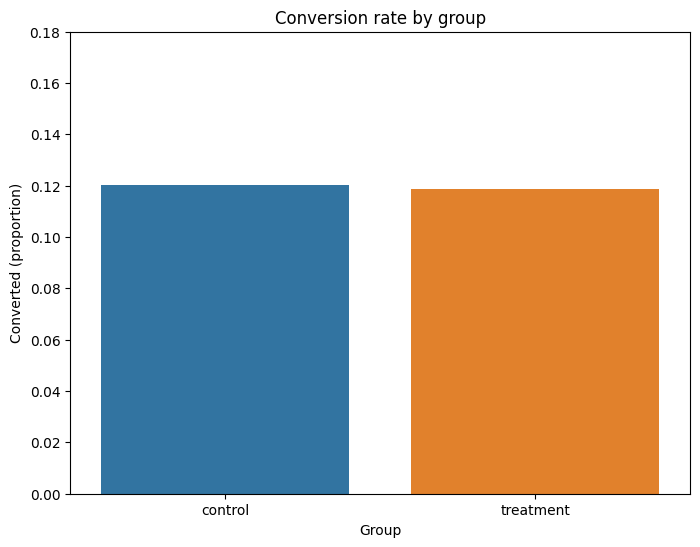

In [7]:
#a = sns.color_palette("Set1")
# visualise conversion rates
plt.figure(figsize = (8,6))
sns.barplot(x = df['group'], 
            y = df['converted'], 
            errorbar=('ci', False))
plt.ylim(0, 0.18)
plt.title('Conversion rate by group')
plt.xlabel('Group')
plt.ylabel('Converted (proportion)')
plt.show()

Befor running the test, we actually should count sample size for tests so they will be statistically significant. The problem here is that we don't know variance, but we could make some assumptions about it if we would have some additional infromation from out dataset.

## Z-test

In [8]:
control_results = df[df['group'] == 'control']['converted']
treatment_results = df[df['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.21
p-value: 0.227
ci 95% for control group: [0.119, 0.122]
ci 95% for treatment group: [0.117, 0.121]


p-value > alpha. This means that we're accepting $H_{0}$ (guess that there is no difference between groups). 


## T-Student's test
Next we will use T-Student's test. We assume here that clicks of users are independent random variables with finite expected value and variance. This means that we can use Сentral Limit Theorem. Actually, T test is more usefull, because we don't have to know variance for samples, that is why it used most of the time in data analysis.

In [9]:
mean_control = control_results.sum()/n_con
mean_treatment = treatment_results.sum()/n_treat
print(f'{mean_control=}, {mean_treatment=}')

mean_control=0.12029717968491792, mean_treatment=0.11884253398646046


Hypotheses here are next:
$$H_{0}\colon \overline{X_{c}} = \overline{X_{t}},$$
$$H_{1}\colon \overline{X_{c}} \neq \overline{X_{t}},$$
where $\overline{X_{c}}, \overline{X_{t}}$ are CTR for both control and treatment groups respectivly. 

In [10]:
pr_1, pr_2 = mean_control, mean_treatment
degree_freedom = n_con + n_treat - 2
standart_error_unpooled = np.sqrt(pr_1*(1 - pr_1)/n_con + pr_2*(1 - pr_2)/n_treat)
t_statistic = abs((mean_control - mean_treatment)/standart_error_unpooled)
p_value = 2*(1 - stats.t.cdf(t_statistic, degree_freedom)) #multiplyed by 2 because test is two-sized

if p_value > 0.05:
    print(f't statistic: {z_stat:.2f}')
    print(f'p value = {p_value:.2f} > 0.05\nNo significant differences')
else:
    print(f'p value = {p_value:.2f} < 0.05\nThere is significant differences')
#t_statistis

t statistic: 1.21
p value = 0.23 > 0.05
No significant differences


Different test, equal results. Also we can note that p-values also are almost exact the same, it's good sign. This lead us to accept $H_{0}$.
%Same test, but using only libraries:

## Welch’s t-test
This test is very simmiliar to classic T-test, but uses another formula to calclulate degree of freedoms for t statistic. Welch's t-test used when there is no any assumptions or information about equality of variances of samples.

In [11]:
t_statistic, p_value = stats.ttest_ind([mean_control], [mean_treatment], equal_var=False)
if p_value > 0.05:
    print(f't statistic: {z_stat:.2f}')
    print(f'p value = {p_value:.2f} > 0.05\nNo significant differences')
else:
    print(f'p value = {p_value:.2f} < 0.05\nThere is significant differences')

p value = nan < 0.05
There is significant differences


C:\Users\Микита\AppData\Local\Temp\ipykernel_13216\2170501545.py:1: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistic, p_value = stats.ttest_ind([mean_control], [mean_treatment], equal_var=False)
C:\Users\Микита\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\Микита\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


## Сonclusions
We conduct A/B testing of CTR for some online store and determine that there is no significant differences in both treatment and control groups. Also was noted that Z and T tests provide similar results.

#Non parametric test, used to determine statistical differences between two samples. It's not very mathces for testing Click #Trough Probability due to the fact that this test don't answers buisness questions about means and medians that usually #stakeholders are interested in. Altough, it will be curious for us to see the results of this test and compare it with previous #ones. 
